In [128]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 12.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 13.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 13.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import time
import numpy as np

In [3]:
from datasetsforecast.m4 import M4

In [4]:
group = 'Monthly'
await M4.async_download('data', group=group)

In [5]:
df, *_ = M4.load(directory='data', group=group)
n_series = len(np.unique(df.unique_id.values))

In [6]:
df["test"] = df["ds"]>df.groupby("unique_id")["ds"].transform(max)-3

/tmp/ipykernel_85122/2645762365.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df["test"] = df["ds"]>df.groupby("unique_id")["ds"].transform(max)-3


In [37]:
train = df[df["test"]==0].sort_values(by=["unique_id","ds"])
test = df[df["test"]==1].sort_values(by=["unique_id","ds"])

In [8]:
from statsforecast import StatsForecast
import time

/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)


In [116]:
# Create a list of models and instantiation parameters
model_names = ["HoltWinters","CrostonClassic","SeasonalNaive","HistoricAverage","DynamicOptimizedTheta"]

models_classes = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=12),
    HistoricAverage(),
    DOT(season_length=12)
]

In [11]:
model_wrappers = []
for model in models_classes:
    model_wrappers.append(
        StatsForecast( 
            models=[model],
            freq="ME", 
            fallback_model = SeasonalNaive(season_length=12),
            n_jobs=-1,
        )
    )    


In [12]:
fit_times = []

for model in model_wrappers:
    start = time.time()
    model.fit(df=train)
    fit_times.append(time.time()-start)
    

In [13]:
fit_times

[3.7768449783325195,
 4.698519945144653,
 3.8190529346466064,
 3.957066059112549,
 140.4564459323883]

In [14]:
forecasts = []
forecast_times = []

for model in model_wrappers:
    start = time.time()
    forecasts.append(model.predict(h=3))
    forecast_times.append(time.time()-start)

In [15]:
forecast_times

[1.8247456550598145,
 1.7690906524658203,
 1.908539056777954,
 1.8806366920471191,
 7.303477048873901]

In [38]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, rmse, rmsse
from functools import partial

metrics = [
    mape,
    rmse,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [66]:
test

,ds,y,test
unique_id,,,
M1,485,4700.0,True
M1,486,4490.0,True
M1,487,4010.0,True
M10,382,5350.0,True
M10,383,5450.0,True
...,...,...,...
M9998,86,1010.0,True
M9998,87,1140.0,True
M9999,85,3800.0,True


In [69]:
test = test.set_index("unique_id")
for forecast in forecasts:
    test = pd.concat([test,forecast.drop(columns="ds").set_index("unique_id")],axis=1)

In [74]:
test = test.drop(columns="test").reset_index()

KeyError: "['test'] not found in axis"

In [76]:
test = test.reset_index()

In [77]:
eval = evaluate(test, metrics=metrics, train_df=train)

In [113]:
metrics = eval.set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

In [117]:
times = pd.DataFrame(
    {
        "Model":model_names,
        "fit_times":fit_times,
        "forecast_times":forecast_times
    }
).set_index("Model")

In [95]:
metrics.groupby(level=[1,2]).median().unstack()

Model,CrostonClassic,DynamicOptimizedTheta,HistoricAverage,HoltWinters,SeasonalNaive
metric,,,,,
mape,0.064953,0.034828,0.257880,0.069984,0.069984
mase,0.749038,0.391666,2.563586,0.775449,0.775449
rmse,256.067470,136.003725,927.576122,267.040967,267.040967
rmsse,0.616899,0.336552,1.988234,0.649283,0.649283


In [137]:
md = metrics.groupby(level=[1,2]).mean().to_frame().join(times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

In [129]:
import seaborn as sns

INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/google-noto-color-emoji-fonts/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error code 0x2)
INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/google-noto-sans-cjk-vf-fonts/NotoSansCJK-VF.ttc: In FT2Font: Can not load face (SFNT font table missing; error code 0x8e)
INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/google-noto-sans-mono-cjk-vf-fonts/NotoSansMonoCJK-VF.ttc: In FT2Font: Can not load face (SFNT font table missing; error code 0x8e)
INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/abattis-cantarell-vf-fonts/Cantarell-VF.otf: In FT2Font: Can not load face (SFNT font table missing; error code 0x8e)
INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/google-noto-serif-cjk-vf-fonts/NotoSerifCJK-VF.ttc: In FT2Font: Can not load face (S

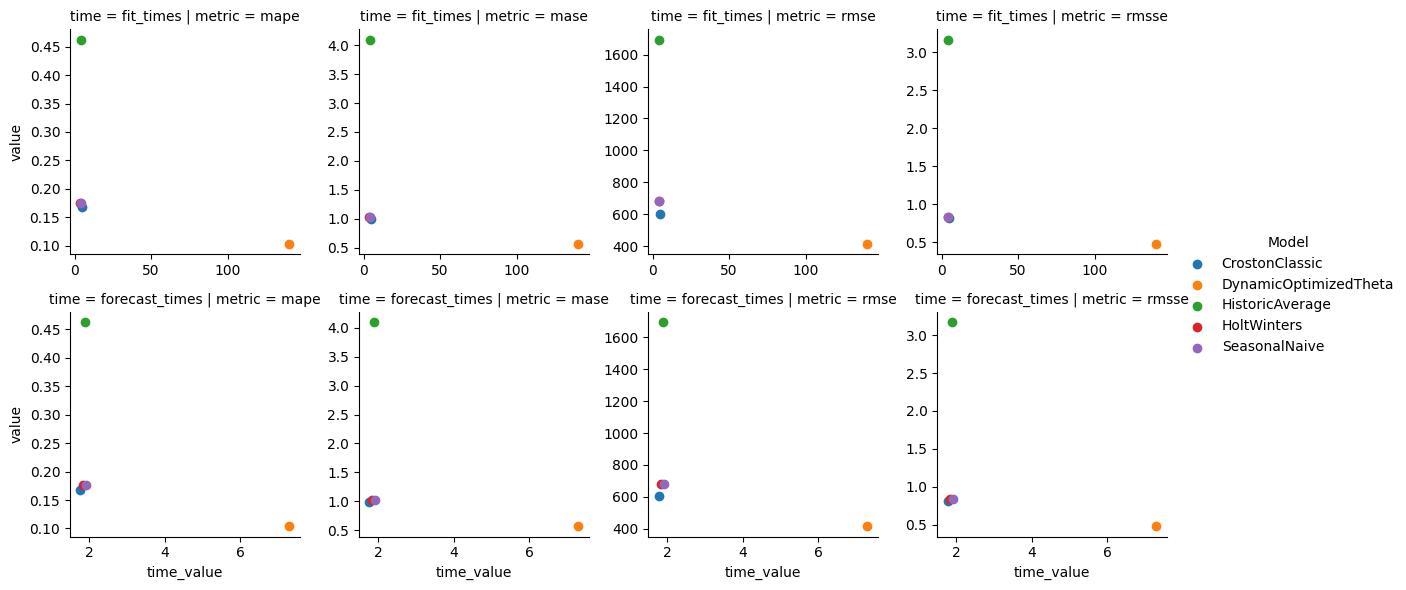

In [143]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(md, row= "time", col="metric", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()